## Import librairies

In [1]:
import torch
from keras.datasets import mnist
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import time
from tqdm.notebook import tqdm
import random

In [2]:
class RBM:
    
    def __init__(self, hidden_dim, visible_dim):
        self.visible_dim = visible_dim
        self.hidden_dim = hidden_dim
        self.W = torch.randn(self.hidden_dim, self.visible_dim) * 0.01
        self.a = torch.zeros(self.visible_dim)
        self.b = torch.zeros(self.hidden_dim)
        self.W.requires_grad = True
        self.a.requires_grad = True
        self.b.requires_grad = True
        
    #La fonction visible_cache permet de retourner P(v|h)
    def visible_cache(self, h):
        return torch.sigmoid(h.mm(self.W) + self.a)
    
    #la fonction cache_visible permet de retourner P(h|v)
    def cache_visible(self, v):
        return torch.sigmoid(v.mm(self.W.T) + self.b)
    
    def loss(self, x, x_tilde):
        return torch.sum(self.E_theta(x), dim=-1) - (x.shape[0]/x_tilde.shape[0]) * torch.sum(self.E_theta(x_tilde), dim=-1)
    
    def E_theta(self, v):
        return -1 * (v@self.a + torch.sum(torch.nn.functional.softplus(v@self.W.T + self.b), dim=-1))
    
    def sample(self, nb_sample, K):
        v = torch.randn((nb_sample, self.visible_dim))
        for k in range(1, K):
            h = torch.bernoulli(self.cache_visible(v))
            v = torch.bernoulli(self.visible_cache(h))
        return v
    
    def train(self, target_samples, batch_size, lr, epochs):
        dataset = torch.utils.data.TensorDataset(target_samples)
        optim = torch.optim.SGD([self.a, self.b, self.W], lr=lr)
        mse = torch.nn.MSELoss()
        loss_ = []
        mse_ = []
        for t in tqdm(range(epochs), total = epochs):
            dataloader = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True)
            for batch in dataloader:
                x = batch[0]
                x_tilde = self.sample(batch_size, 100)
                loss = self.loss(x, x_tilde)
                loss_.append(loss.data)
                optim.zero_grad()    # remise à zéros du gradient
                loss.backward()      # trouve les poids de [self.a, self.b, self.W] par rapport à loss
                optim.step()         # Met à jour les valeurs du gradient
                new_x = self.visible_cache(self.cache_visible(x))
                mse_.append(mse(x,new_x).data)
        return loss_, mse_
            
    def get_img(self, x):
        x = x.clone().detach().numpy()
        x[x<=0.5] = 0
        x[x>0.5] = 255
        img = x.reshape(28, 28)
        return img

In [22]:
class Tester:
    
    """
    __init__() :
    allow to create the RBM with specific parameters
    """
    def __init__(self, hidden_dim, batch_size, epochs, lr, y_value):
        self.hidden_dim = hidden_dim
        self.visible_dim = 784
        self.batch_size = batch_size
        self.epochs = epochs
        self.lr = lr
        self.y_value = y_value
        self.RBM = []
        for h_dim in self.hidden_dim:
            self.RBM.append(RBM(h_dim, self.visible_dim))
       
    """
    train() :
    allow to train the RBM
    """
    def train(self, generate_img = False):
        (self.x_train, self.y_train), _ = mnist.load_data()
        extracter = []
        if self.y_value == -1:
            extracted = self.x_train[:10000]
        else :
            extracted = self.x_train[self.y_train==self.y_value]
        target_samples = torch.tensor(extracted>.5).reshape(extracted.shape[0], 28*28).float()
        for idx, RBM in enumerate(self.RBM):
            print("-------- TRAIN RBM", idx, "--------")
            for batch_size_ in self.batch_size:
                for lr_ in self.lr:
                    for epochs_ in self.epochs:
                        print("Batch_size :", batch_size_)
                        print("Learning rate :", lr_)
                        print("Epochs :", epochs_)
                        loss, mse = RBM.train(target_samples, batch_size_, lr_, epochs_)
                        self.plot_img(RBM, loss, mse)
                        if generate_img == True:
                            self.generate_images(RBM)
                        
    """
    plot_img() :
    allow to plot graphs and generated images
    """                   
    def plot_img(self, RBM, loss, mse):
        img, img_imp = self.improve_img(RBM)
        img_gen = self.generate_img(RBM)
        fig = plt.figure(figsize=(21,5))

        ax1 = fig.add_subplot(1,5,1)
        ax1.plot(loss, label="Function Loss value")
        ax1.legend()
        ax1.set_title("Loss curve")

        ax2 = fig.add_subplot(1,5,2)
        ax2.plot(mse, label="MSE value")
        ax2.legend()
        ax2.set_title("MSE curve")

        ax3 = fig.add_subplot(1,5,3)
        ax3.imshow(img_imp, cmap='gray')
        ax3.set_title("Input image")

        ax4 = fig.add_subplot(1,5,4)
        ax4.imshow(img_imp, cmap='gray')
        ax4.set_title("Improve image")

        ax5 = fig.add_subplot(1,5,5)
        ax5.imshow(img_gen, cmap='gray')
        ax5.set_title("Generate image")
        plt.show()
    
    """
    improve_img() :
    allow to generate a new image from a image in the y_train
    """
    def improve_img(self, RBM):
        rand = random.randint(0, 9)
        x = self.x_train[self.y_train==rand][2]
        if self.y_value != -1:
            x = self.x_train[self.y_train==self.y_value][2]
        x = torch.FloatTensor(x).reshape(1, self.visible_dim)
        x_reconstruit = RBM.visible_cache(RBM.cache_visible(x))
        img_imp = RBM.get_img(x_reconstruit)
        return x, img_imp

    """
    generate_img() :
    allow to generate a new image from a random distribution
    """
    def generate_img(self, RBM):
        x_reconstruit = RBM.sample(1, 30)
        img_gen = RBM.get_img(x_reconstruit)
        return img_gen
    
    """
    generate_images()
    allow to generate several images
    """
    def generate_images(self, RBM):
        fig = plt.figure(figsize=(21,5))
        for i in range(10):
            x_reconstruit = RBM.sample(1, 30)
            img_gen = RBM.get_img(x_reconstruit)        
            ax1 = fig.add_subplot(1,10,i+1)
            ax1.imshow(img_gen, cmap='gray')
            ax1.set_title("Image"+str(i+1))
        plt.show() 


# Test d'entraînement du modèle
Ci-dessous, vous pouvez comparer l'influence de différents paramètres (hidden_dim, batch_size, epochs et learning rate) sur le modèle. Pour comparer l'impact de chaque paramètre sur le modèle, vous pouvez donner en argument de la classe Tester une liste de valeur pour chaque paramètre. Ainsi, libre à vous de regarder l'impact d'un paramètre en particulier ou de trouver le modèle le plus optimal en donnant une liste de valeur pour chaque de paramètre.

## Comparaison de l'influence des paramètres
Ci-dessous, nous comparons l'influence de chaque paramètre un à un, mais pour faciliter la comparaison nous travaillerons qu'avec des images de 5. 

### Paramètre hidden_dim
Observons ensemble l'impact du paramètre hidden_dim sur le modèle.

-------- TRAIN RBM 0 --------
Batch_size : 20
Learning rate : 0.001
Epochs : 20


  0%|          | 0/20 [00:00<?, ?it/s]

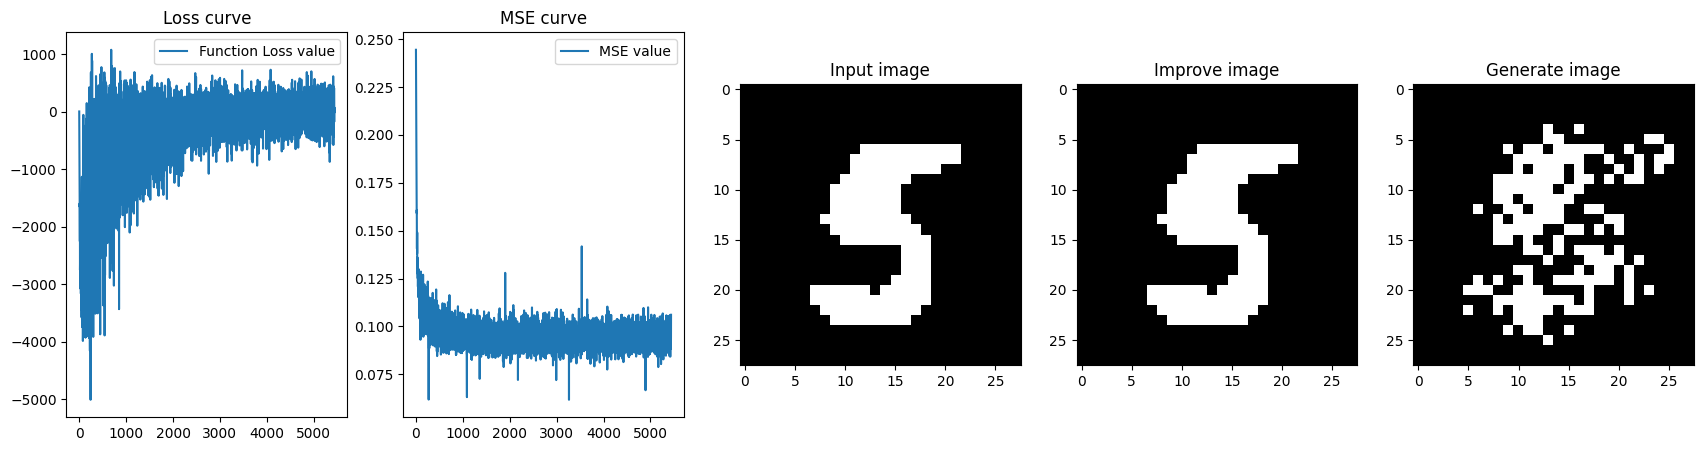

-------- TRAIN RBM 1 --------
Batch_size : 20
Learning rate : 0.001
Epochs : 20


  0%|          | 0/20 [00:00<?, ?it/s]

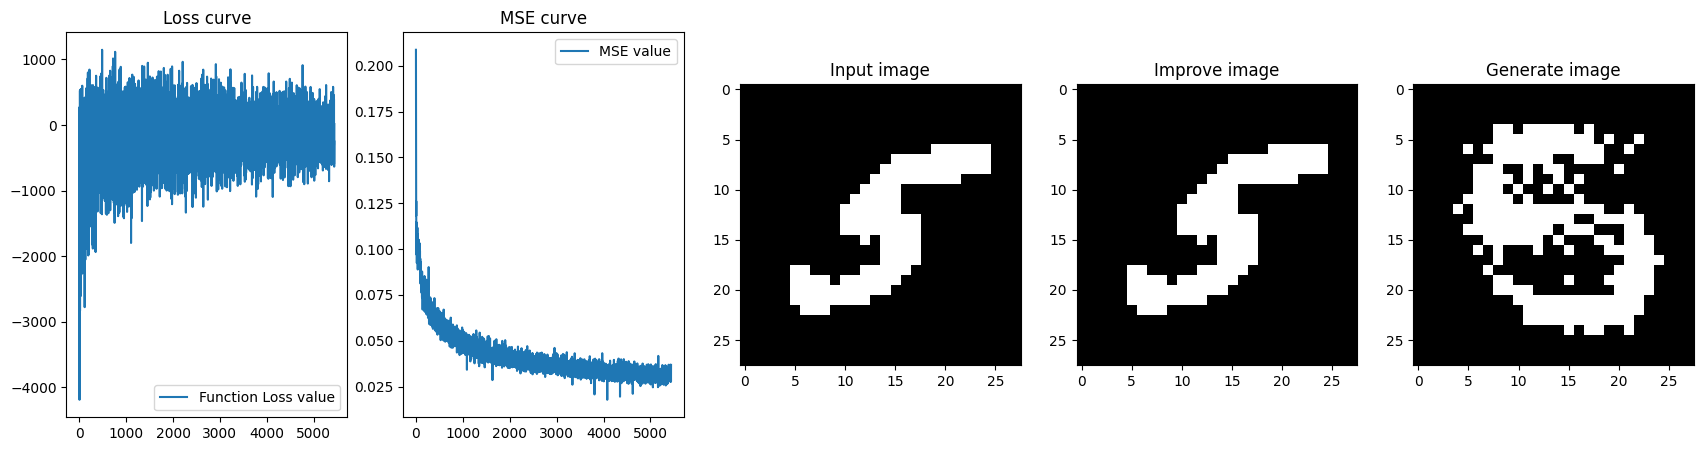

-------- TRAIN RBM 2 --------
Batch_size : 20
Learning rate : 0.001
Epochs : 20


  0%|          | 0/20 [00:00<?, ?it/s]

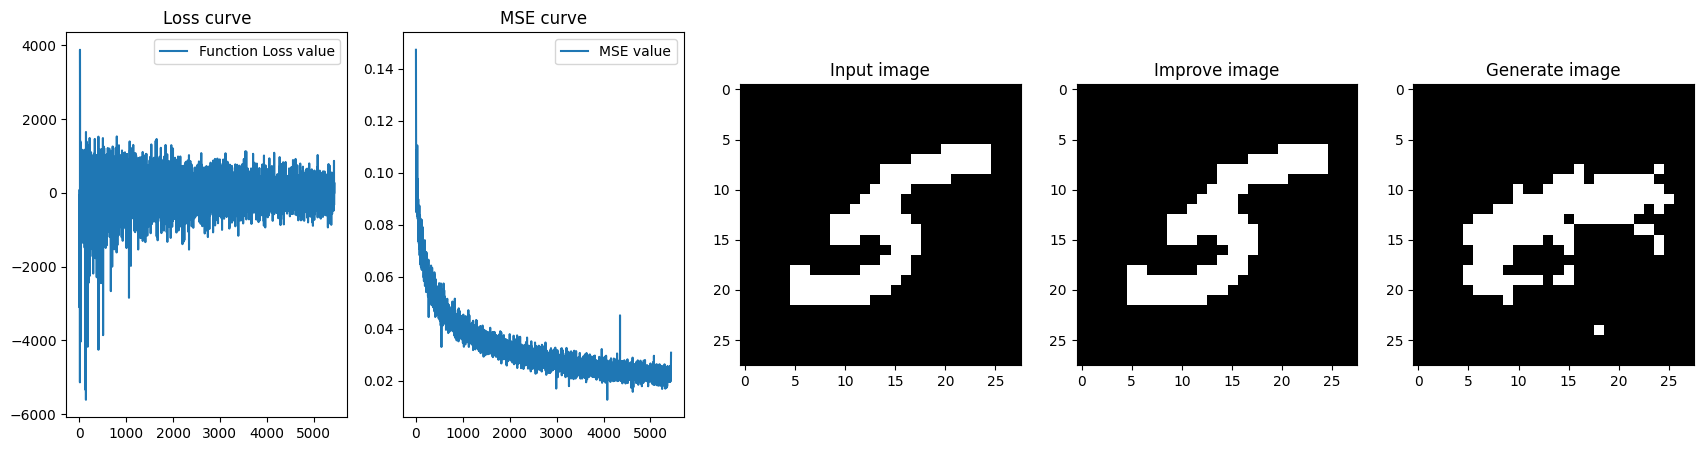

-------- TRAIN RBM 3 --------
Batch_size : 20
Learning rate : 0.001
Epochs : 20


  0%|          | 0/20 [00:00<?, ?it/s]

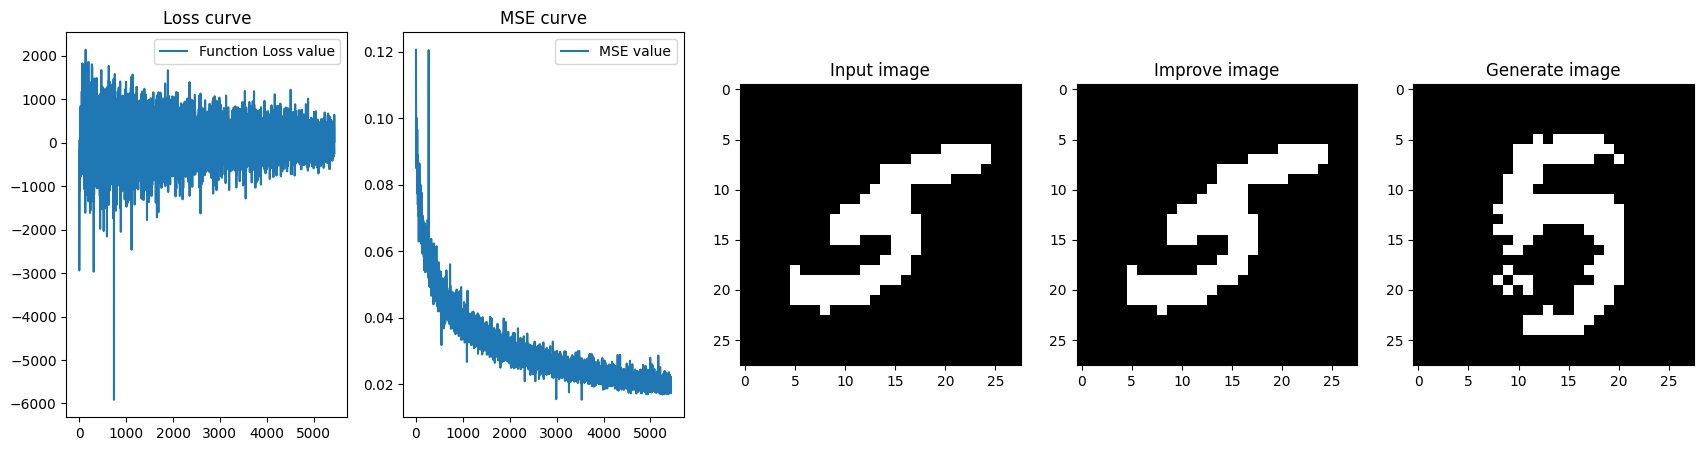

-------- TRAIN RBM 4 --------
Batch_size : 20
Learning rate : 0.001
Epochs : 20


  0%|          | 0/20 [00:00<?, ?it/s]

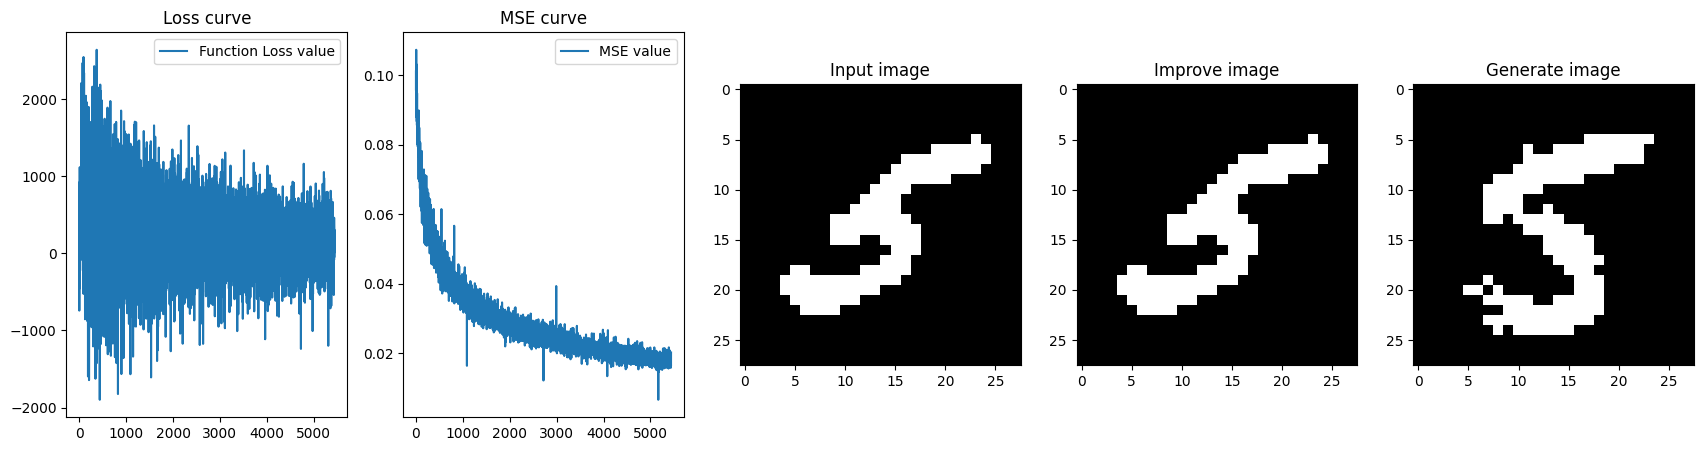

In [25]:
hidden_dim = [10, 100, 300, 500, 1000]
batch_size = [20]
epochs = [20]
lr = [0.001]
y_value = 5
tester = Tester(hidden_dim, batch_size, epochs, lr, y_value)
tester.train()

On observe que plus la dimension de la couche cachée (hidden_dim), plus les images sont épurées. Ceci est cohérent, car le modèle dispose de plus de caractèristique pour établir la distribution de probabilité du jeu de données avec lequel le modèle s'est entraîné. Cependant, plus la dimension de la couche cachée est grande plus le modèle est long à apprendre. 
Prenons le temps de décrire l'image générée avec un hidden_dim = 300, une raison qui pourrait expliquer cette génération serait la valeur de K dans le la fonction sample du RBM qui n'est peut-être pas assez grande et donc n'a pas permis d'afficher la distribution de probabilité d'un cinq.

### Paramètre batch_size
Observons ensemble l'impact du paramètre batch_size sur le modèle. Nous travaillerons avec le paramètre hidden_dim = 300, car de manière générale c'est la valeur avec j'ai pu obtenir les meilleures images.

-------- TRAIN RBM 0 --------
Batch_size : 20
Learning rate : 0.001
Epochs : 20


  0%|          | 0/20 [00:00<?, ?it/s]

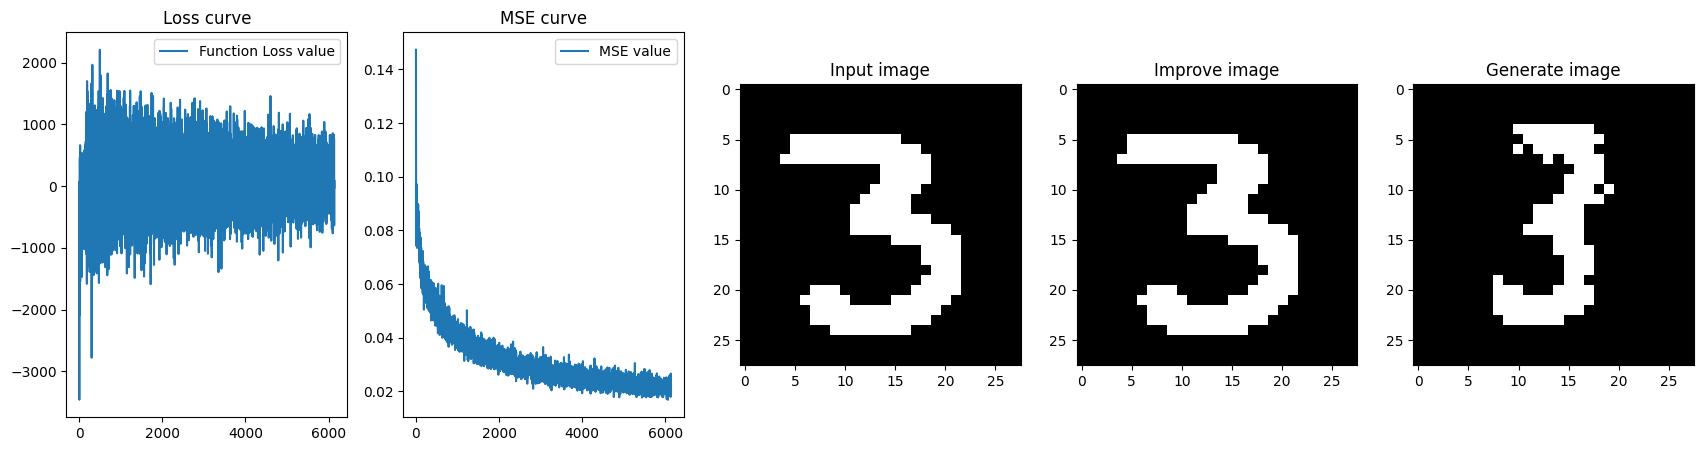

Batch_size : 64
Learning rate : 0.001
Epochs : 20


  0%|          | 0/20 [00:00<?, ?it/s]

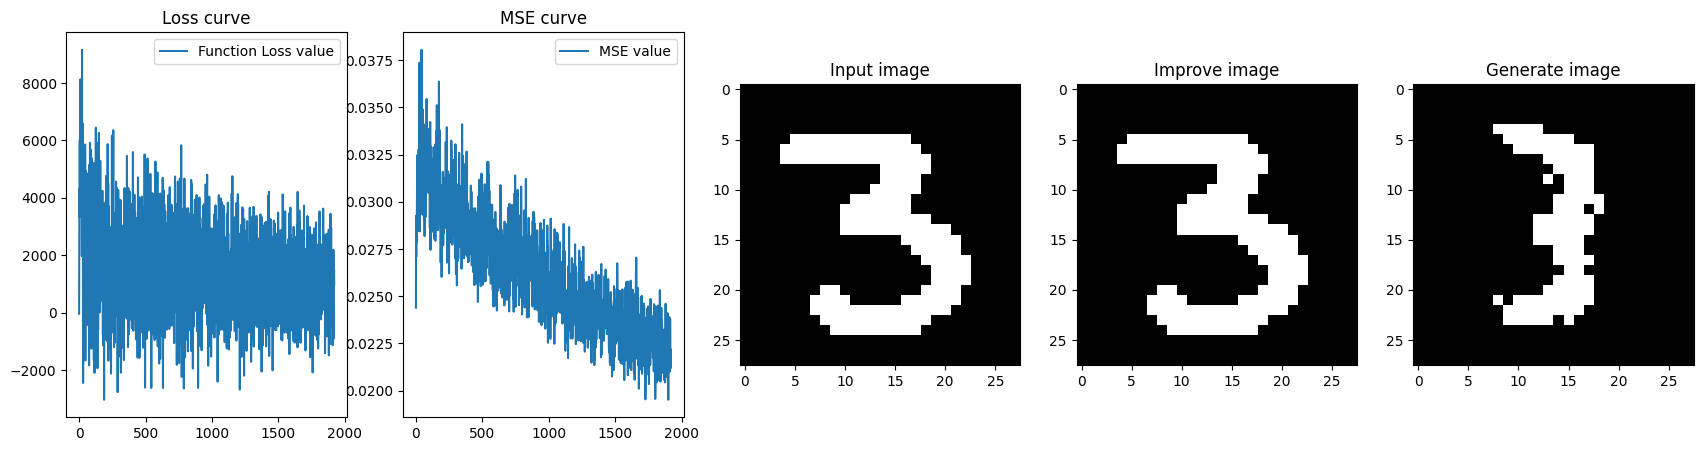

Batch_size : 128
Learning rate : 0.001
Epochs : 20


  0%|          | 0/20 [00:00<?, ?it/s]

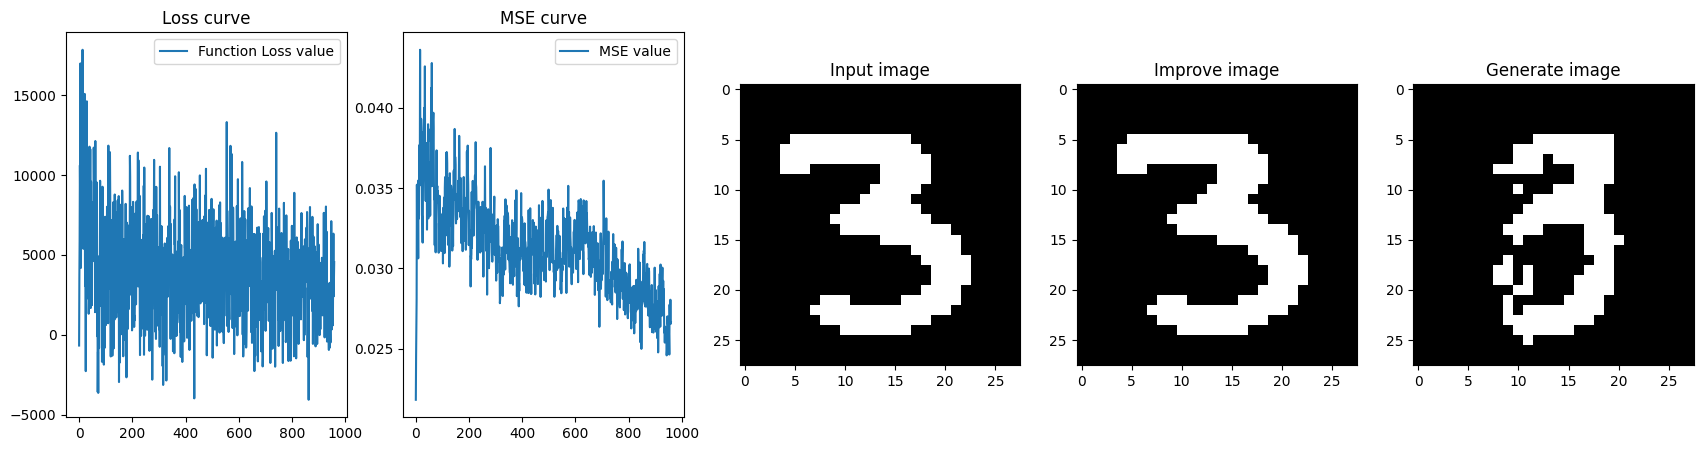

Batch_size : 256
Learning rate : 0.001
Epochs : 20


  0%|          | 0/20 [00:00<?, ?it/s]

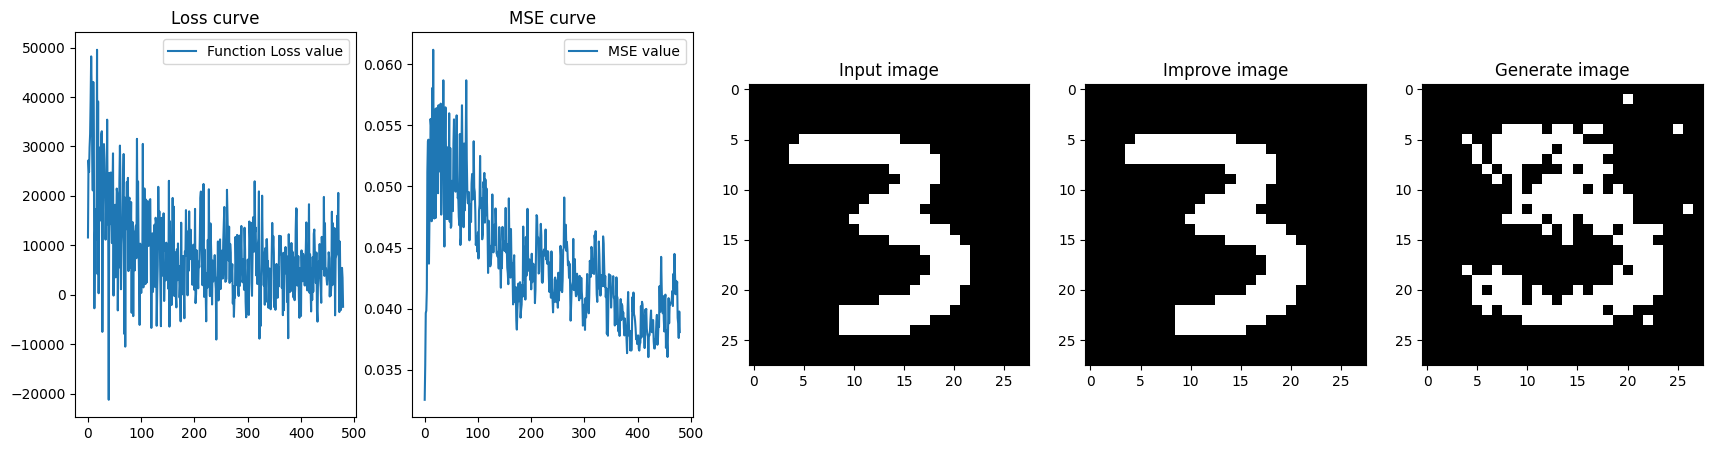

In [26]:
hidden_dim = [300]
batch_size = [20, 64, 128, 256]
epochs = [20]
lr = [0.001]
y_value = 3
tester = Tester(hidden_dim, batch_size, epochs, lr, y_value)
tester.train()

On observe que plus le batch_size est grand, plus la MSE du modèle converge vite vers 0. Cependant, on observe également que plus le batch_size est grand, moins l'image est épurées et donc lisible. 

### Paramètre epochs
Observons ensemble l'impact du paramètre epochs sur le modèle.

-------- TRAIN RBM 0 --------
Batch_size : 20
Learning rate : 0.001
Epochs : 5


  0%|          | 0/5 [00:00<?, ?it/s]

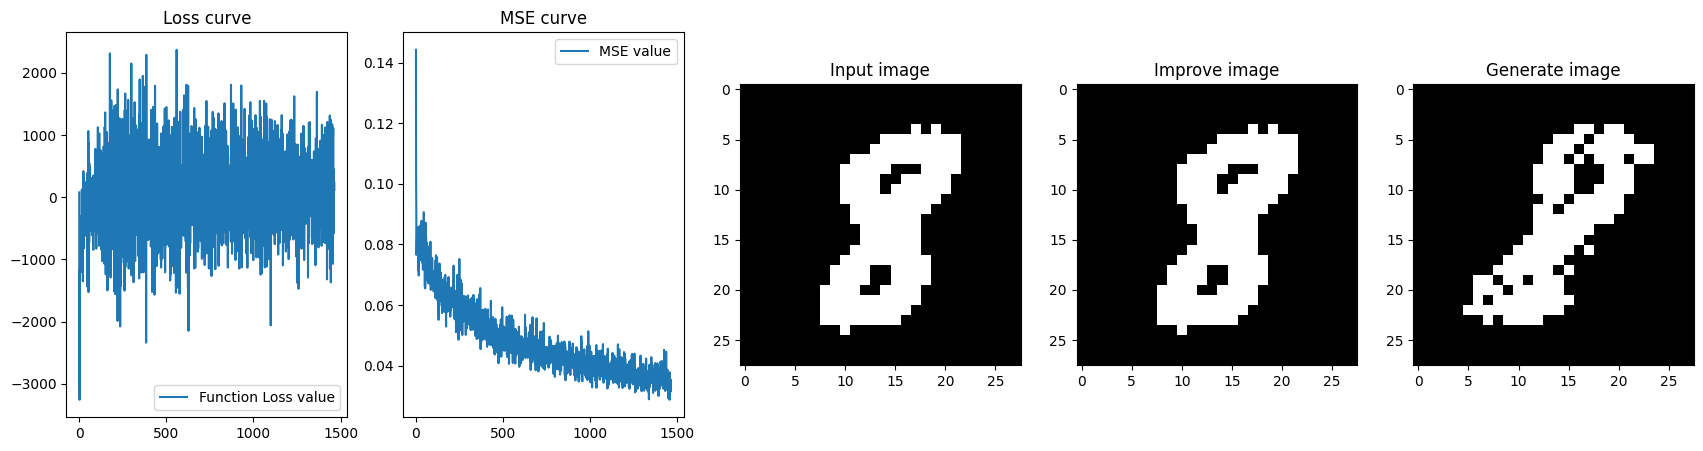

Batch_size : 20
Learning rate : 0.001
Epochs : 10


  0%|          | 0/10 [00:00<?, ?it/s]

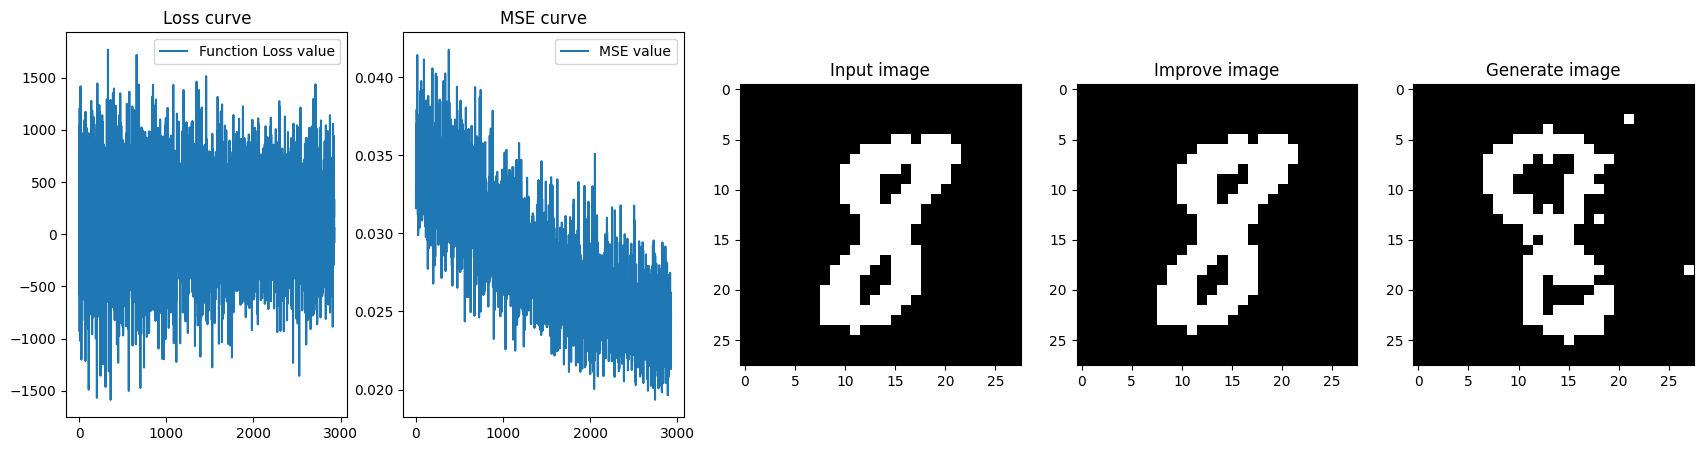

Batch_size : 20
Learning rate : 0.001
Epochs : 15


  0%|          | 0/15 [00:00<?, ?it/s]

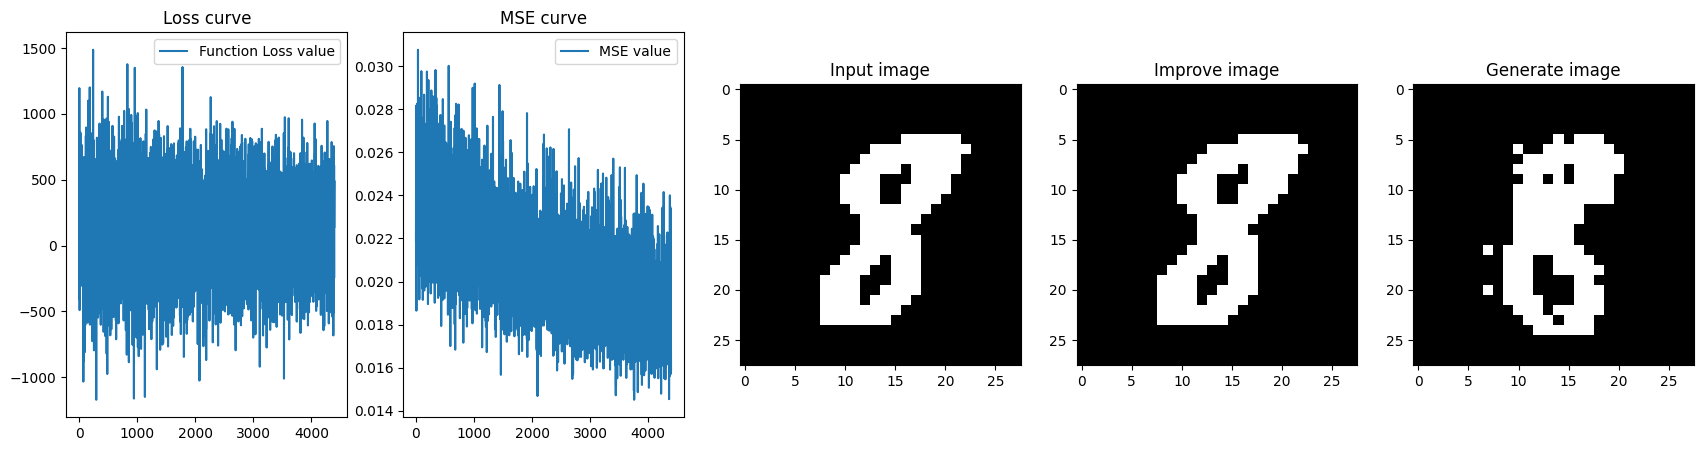

Batch_size : 20
Learning rate : 0.001
Epochs : 20


  0%|          | 0/20 [00:00<?, ?it/s]

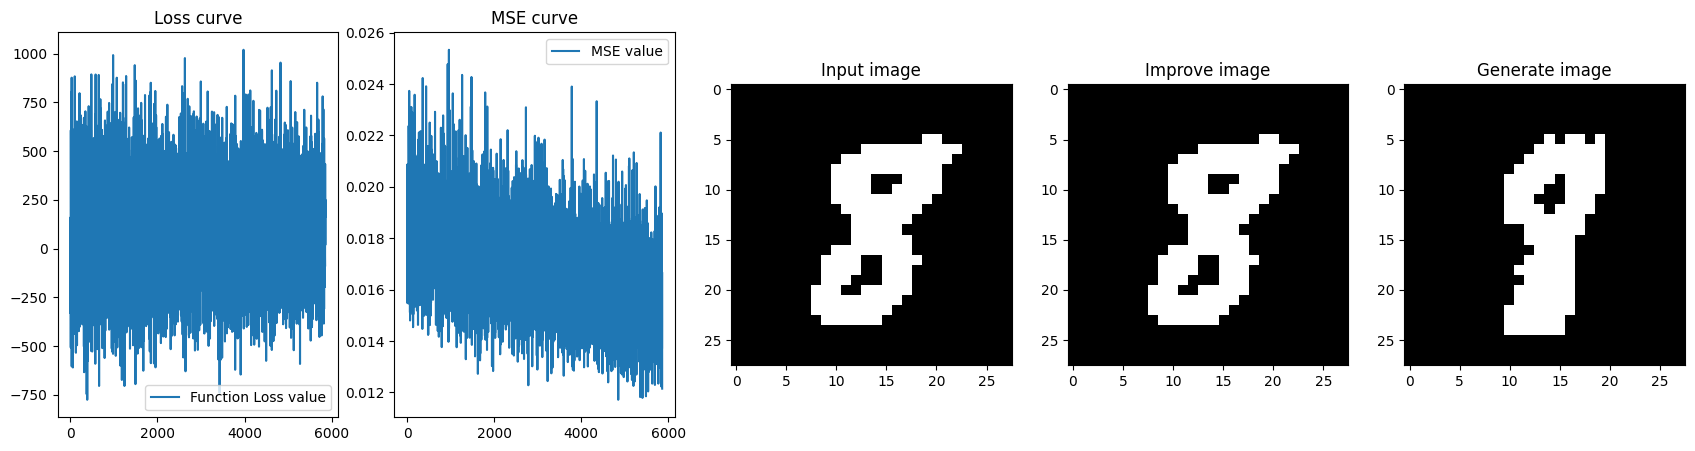

In [27]:
hidden_dim = [300]
batch_size = [20]
epochs = [5, 10, 15, 20]
lr = [0.001]
y_value = 8
tester = Tester(hidden_dim, batch_size, epochs, lr, y_value)
tester.train()

On observe qu'en fonction des autres paramètres (hidden_dim, batch_size, learning rate), un grand nombre d'epochs peut être pertinent. Dans notre cas, on observe que la MSE peut encore diminuer, cependant, on observe que les images générées commencent a être trop lisées ce qui risque de produire des images qui ne ressembleront pas à un chiffre.

### Paramètre learning rate
Observons ensemble l'impact du paramètre learning rate sur le modèle.

-------- TRAIN RBM 0 --------
Batch_size : 20
Learning rate : 0.001
Epochs : 20


  0%|          | 0/20 [00:00<?, ?it/s]

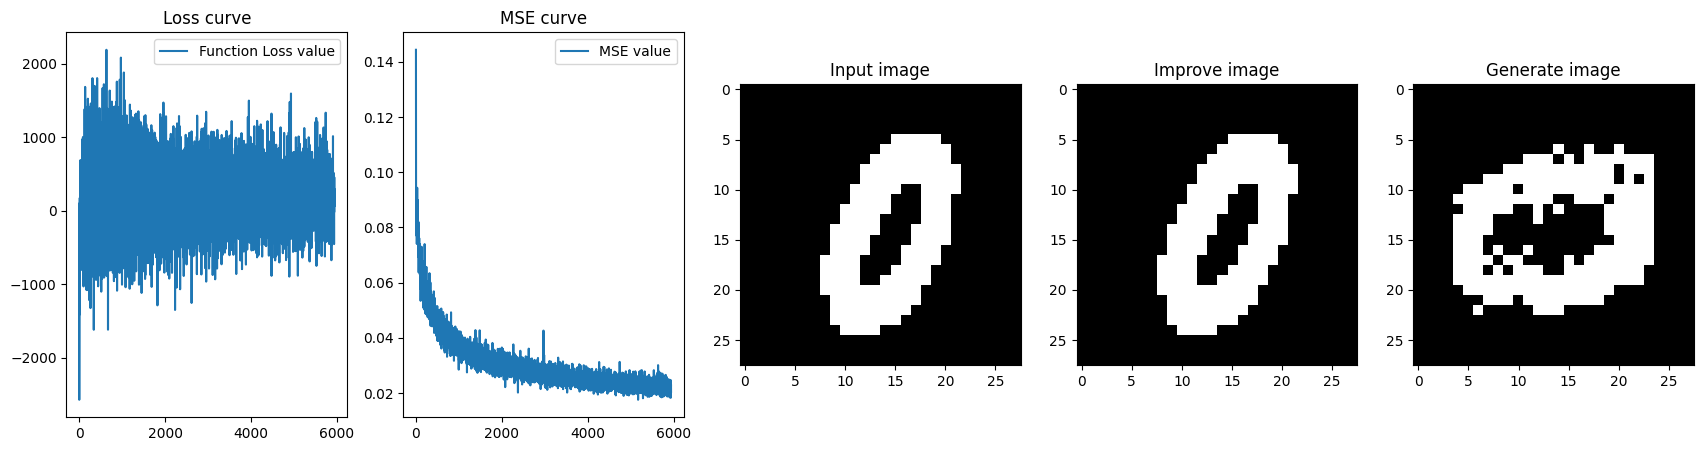

Batch_size : 20
Learning rate : 0.003
Epochs : 20


  0%|          | 0/20 [00:00<?, ?it/s]

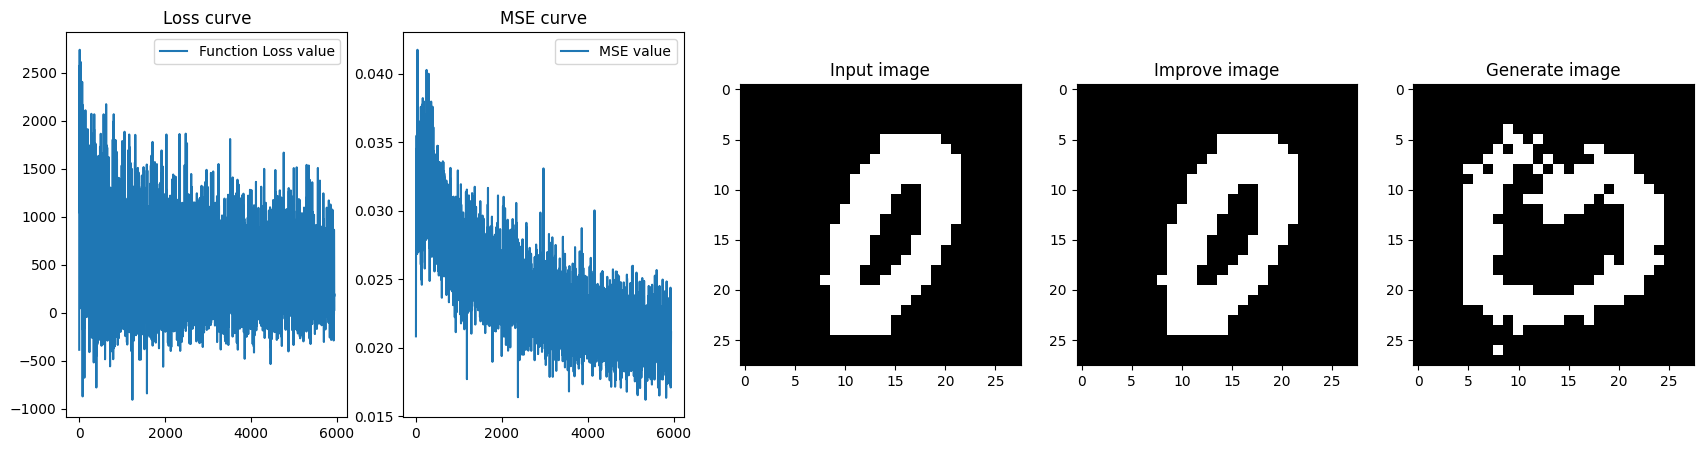

Batch_size : 20
Learning rate : 0.01
Epochs : 20


  0%|          | 0/20 [00:00<?, ?it/s]

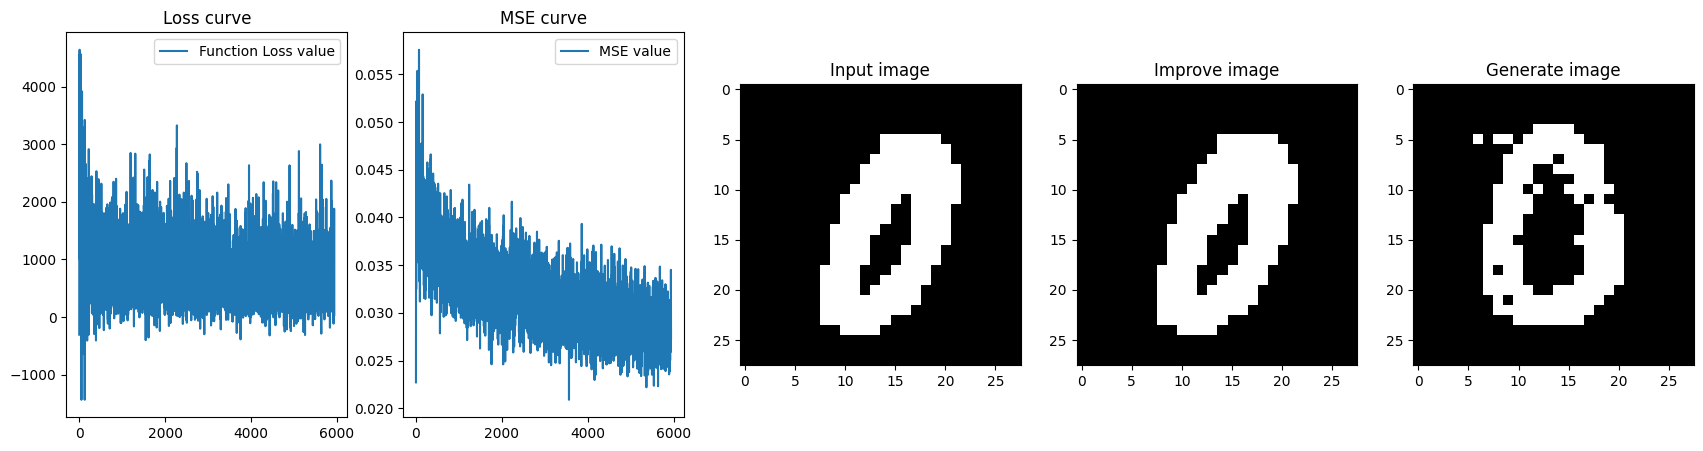

Batch_size : 20
Learning rate : 0.1
Epochs : 20


  0%|          | 0/20 [00:00<?, ?it/s]

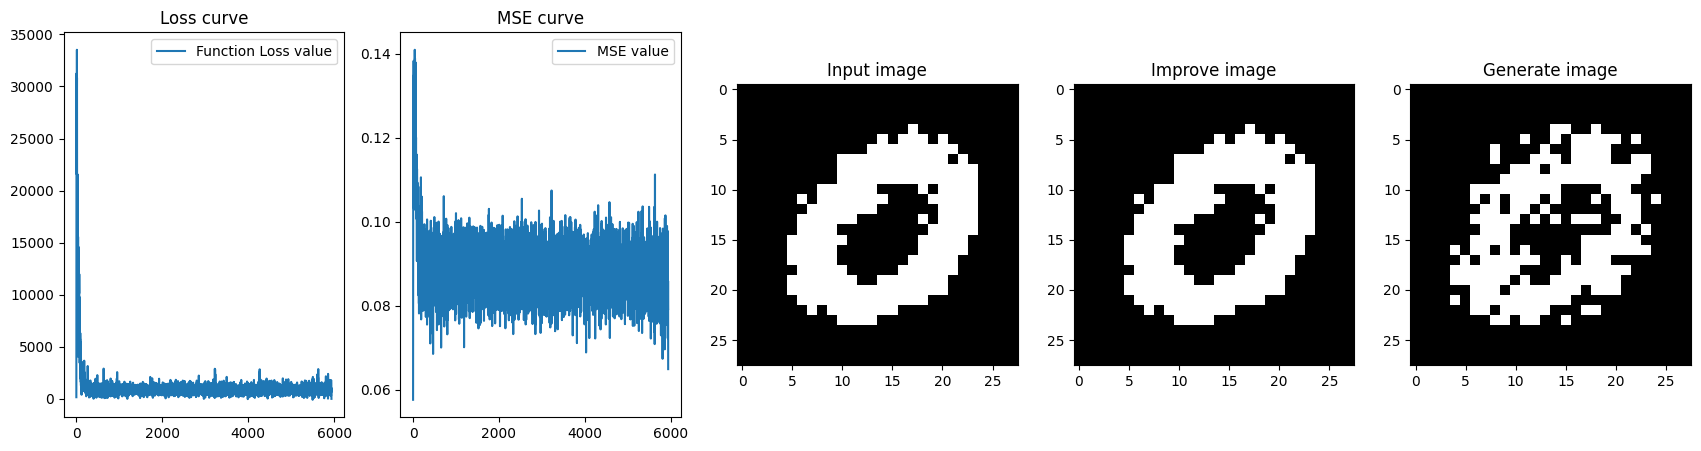

In [28]:
hidden_dim = [300]
batch_size = [20]
epochs = [20]
lr = [0.001, 0.003, 0.01, 0.1]
y_value = 0
tester = Tester(hidden_dim, batch_size, epochs, lr, y_value)
tester.train()

On observe que le learning rate est pertinent en fonction des paramètres (hidden_dim, batch_size et epochs). De manière générale, un grand learning rate ne nous permettra pas d'apporcher efficacement un mimimum global. Ceci explique les résultats avec un learning rate de 0.01 et 0.1 où les valeurs de la loss ont du mal à s'approcher de 0.

## Recherchons le modèle optimale
Ci-dessous, vous trouverez un modèle optimal avec différentes images générées à partir de ce modèle.

-------- TRAIN RBM 0 --------
Batch_size : 20
Learning rate : 0.001
Epochs : 10


  0%|          | 0/10 [00:00<?, ?it/s]

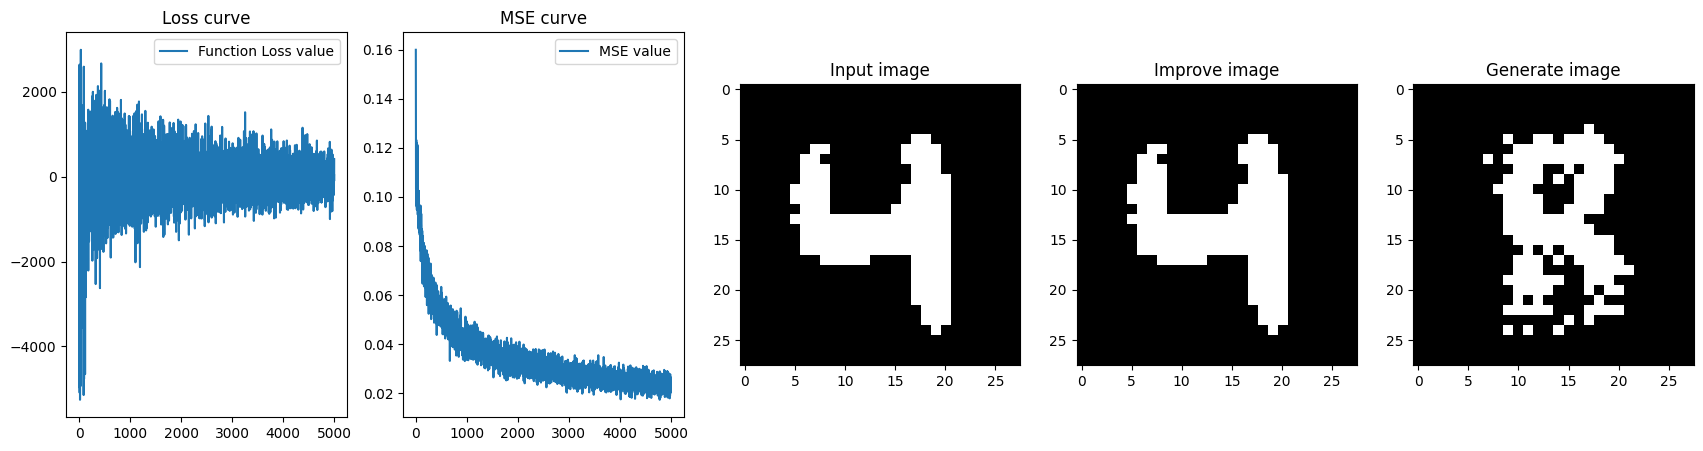

In [33]:
hidden_dim = [300]
batch_size = [20]
epochs = [10]
lr = [0.001]
y_value = -1
tester = Tester(hidden_dim, batch_size, epochs, lr, y_value)
tester.train()

## Générons de nouvelles images
Ci-dessous, nous allons générer de nouvelles images à l'aide de notre modèle optimal.

-------- TRAIN RBM 0 --------
Batch_size : 20
Learning rate : 0.001
Epochs : 10


  0%|          | 0/10 [00:00<?, ?it/s]

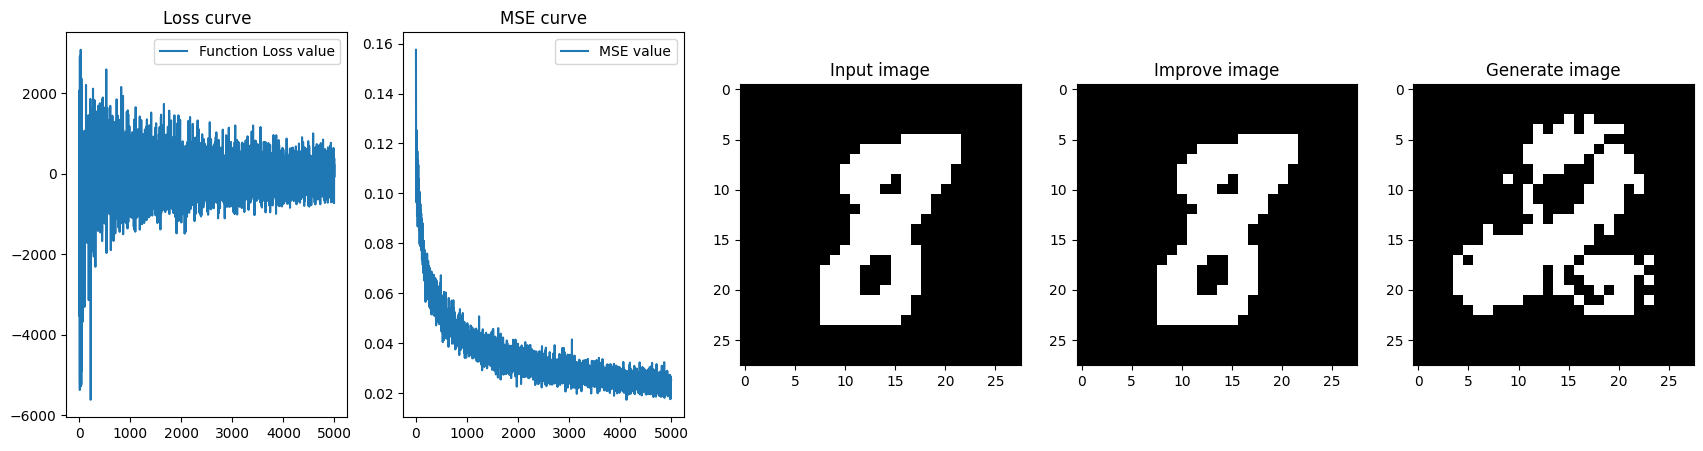

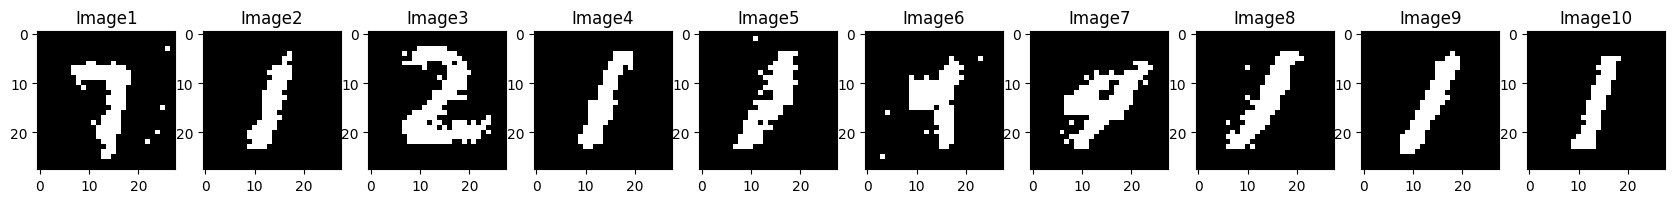

In [32]:
hidden_dim = [300]
batch_size = [20]
epochs = [10]
lr = [0.001]
y_value = -1
tester = Tester(hidden_dim, batch_size, epochs, lr, y_value)
tester.train(True)